# MNIST LSTM Classifier
## Treating an image as a sequence, with a Many-To-One Method
In this Notebook we see how we can use an LSTM as a many to one model that takes in a sequence of data and provides a single output at the end of the sequence.<br>
As an example we use the MNIST dataset and "patchify" it, splitting the image into a sequence of patches and passing them to the model one patch at a time.

[<img src="https://static.packt-cdn.com/products/9781789346640/graphics/assets/79db1776-f471-4fe6-89b0-67cbae844bfc.png">](LSTM)
<br>
[Corresponding Tutorial Video](https://youtu.be/lyUT6dOARGs)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
import torchvision

from tqdm.notebook import trange, tqdm

In [2]:
# The size of our mini batches
batch_size = 128

# How many itterations of our dataset
num_epochs = 50

# Optimizer learning rate
learning_rate = 1e-4

# Where to load/save the dataset from 
data_set_root = "../../datasets"

device = torch.device(0 if torch.cuda.is_available() else 'cpu')

## Create MNIST Dataset and Dataloader

In [3]:
# Prepare a composition of transforms
# transforms.Compose will perform the transforms in order
# NOTE: some transform only take in a PIL image, others only a Tensor
# EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
# Refer to documentation
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.308])])

# Note: ToTensor() will scale unit8 and similar type data to a float and re-scale to 0-1
# Note: We are normalizing with the dataset mean and std 

In [4]:
# Define our MNIST Datasets
# Can also try with CIFAR10 Dataset
# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
train_data = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.MNIST(data_set_root, train=False, download=True, transform=transform)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# that are the sizes we gave it
# Note: we can split it into to more then two pieces!
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# IMPORTANT TO KNOW!!!!!!!!!
# Here we pass the random_split function a manual seed, this is very important as if we did not do this then 
# everytime we randomly split our training and validation set we would get different splits!!!
# For example if we saved our model and reloaded it in the future to train some more, the dataset that we now use to
# train with will undoubtably contain datapoints that WERE in the validation set initially!!
# Our model would therefore be trained with both validation and training data -- very bad!!!
# Setting the manual seed to the same value everytime prevents this!

In [5]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [6]:
# Create the training, Validation and Evaluation/Test Datasets
# It is best practice to separate your data into these three Datasets
# Though depending on your task you may only need Training + Evaluation/Test or maybe only a Training set
# (It also depends on how much data you have)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataloader
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)

In [7]:
# Function to turn a batch of images into a sequence of patches

def extract_patches(image_tensor, patch_size=8):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxCx8x8, where L is the number of patches in each dimension
    # For each dimension, number of patches = (original dimension size) // patch_size
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c, patch_size, patch_size)
    
    return unfolded

In [8]:
# Create a dataloader itterable object
dataiter = next(iter(test_loader))
# Sample from the itterable object
test_images, test_labels = dataiter

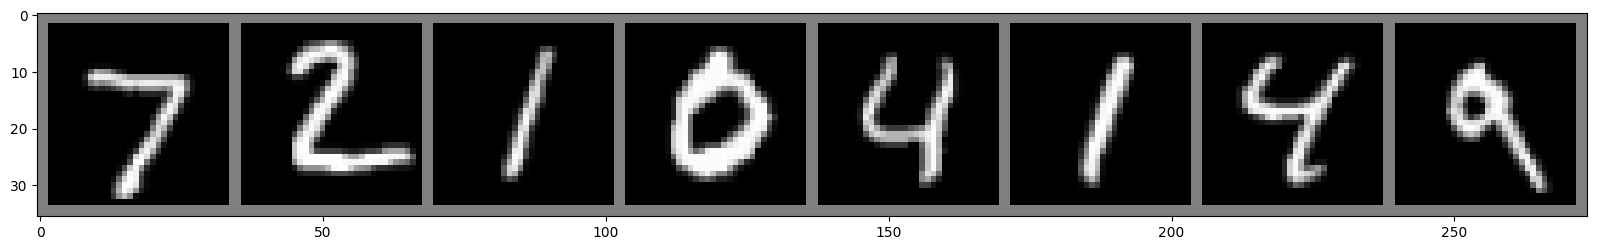

In [9]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Sequence Length 64


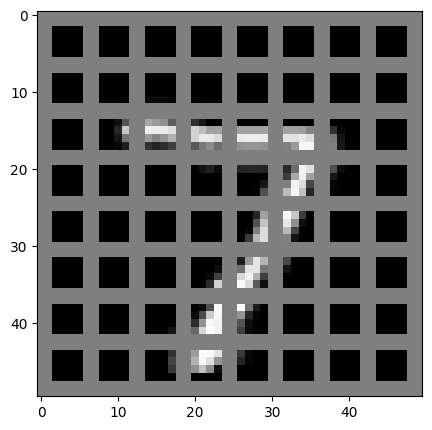

In [10]:
# Set the patch size for extraction
patch_size = 4

# Extract patches from the test images using the defined function
patches = extract_patches(test_images, patch_size=patch_size)

# Calculate the grid size for visualization
grid_size = test_images.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

# Visualize the patches as a grid
plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches[0], grid_size, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))

## Create Image Patch LSTM
This model uses an LSTM network for sequential image data processing. It divides input images into patches and then feeds them into the LSTM layer for sequential analysis. Residual blocks are incorporated within the LSTM to enhance gradient flow and capture temporal dependencies. Finally, the output is passed through a fully connected layer for prediction.

In [11]:
# Define a residual block for MLP architecture
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Define layer normalization for input size
        self.norm1 = nn.LayerNorm(input_size)
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, input_size//2)
        
        # Layer normalization for input size // 2
        self.norm2 = nn.LayerNorm(input_size//2)
        # Second fully connected layer
        self.fc2 = nn.Linear(input_size//2, output_size)
        
        # Final fully connected layer
        self.fc3 = nn.Linear(input_size, output_size)
        
        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        # Apply layer normalization and activation function
        x = self.act(self.norm1(x))
        # Calculate skip connection
        skip = self.fc3(x)
        
        # Apply layer normalization, fully connected layer, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        # Add skip connection
        return x + skip


# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, output_size=10, patch_size=4, lstm_layers=1, hidden_size=64, num_blocks=1):
        super(LSTM, self).__init__()
        
        # Define a fully connected layer for input data
        self.fc_in = nn.Linear(patch_size**2, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=lstm_layers, batch_first=True)
              
        # Define residual blocks
        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, output_size)
        
        # Activation function
        self.act = nn.ELU()
        self.patch_size = patch_size

    def forward(self, input_data, hidden_in, mem_in):
        # Turn the images into a sequence of patches which will be passed to the model one at a time
        bs, c, h, w = input_data.shape
        input_seq = extract_patches(input_data, self.patch_size).reshape(bs, -1, self.patch_size**2)

        # A linear layer will process the patches independently like a batch
        x = self.act(self.fc_in(input_seq))
        
        # The LSTM will process the sequence of patches sequentially
        output, (hidden_out, mem_out) = self.lstm(x, (hidden_in, mem_in))
        
        # We'll get an output from the model from every time-step but we'll only calculate the loss at
        # the last timestep
        x  = self.act(self.res_blocks(output))
        
        return self.fc_out(x), hidden_out, mem_out

## Create Model and Setup training

In [12]:
# Create model
# We instantiate an LSTM model for processing MNIST data. 
# The model architecture includes multiple LSTM layers, each followed by residual blocks for feature enhancement.
# Hyperparameters such as output size, patch size, number of LSTM layers, and hidden size are defined here.

# We can stack multiple LSTM blocks together in our model
lstm_layers = 3

# Hidden size for the LSTM layers
hidden_size = 32

# Instantiate the LSTM model with defined parameters and move it to the appropriate device (CPU or GPU)
mnist_lstm = LSTM(output_size=10, patch_size=patch_size, 
                  lstm_layers=lstm_layers, hidden_size=hidden_size).to(device)

# Initialize the optimizer with above parameters
# We use the Adam optimizer for training the model with the specified learning rate.
optimizer = optim.Adam(mnist_lstm.parameters(), lr=learning_rate)

# Define the loss function
# For classification tasks like MNIST digit recognition, we use cross-entropy loss as the loss function.
loss_fn = nn.CrossEntropyLoss()  

# Initialize training and validation loss and accuracy loggers
training_loss_logger = []
training_acc_logger = []
valid_loss_logger = []
valid_acc_logger = []

In [13]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in mnist_lstm.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 28442 (Approximately 0 Million) Parameters!


## Training

In [14]:
# Train the model
train_acc = 0
valid_acc = 0

# Initialize a progress bar to track epochs and display training and validation accuracies
pbar = trange(0, num_epochs, leave=False, desc="Epoch")    
for epoch in pbar:
    # Update the progress bar with current training and validation accuracies
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))

    # Set the model to training mode
    mnist_lstm.train()
    train_acc = 0
    
    # Iterate through the training data loader
    for data, label in tqdm(train_loader, desc="Training", leave=False):
        # Move data and labels to the appropriate device
        data = data.to(device)
        label = label.to(device)
        
        # Initialize the hidden states and memory buffers with zeros
        hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)
        memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)

        # Forward pass through the model
        data_pred, hidden, memory = mnist_lstm(data, hidden, memory)
        
        # Select the output from the last time step for calculating loss
        last_target = data_pred[:, -1, :]

        # Calculate the loss
        loss = loss_fn(last_target, label)
            
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log training loss and calculate training accuracy
        training_loss_logger.append(loss.item())
        train_acc += (last_target.argmax(1) == label).sum()
        
    # Calculate and log training accuracy
    train_acc = (train_acc/len(train_data)).item()
    training_acc_logger.append(train_acc)
        
    # Set the model to evaluation mode
    mnist_lstm.eval()
    valid_acc = 0
    
    # Validate the model
    with torch.no_grad():
        # Iterate through the validation data loader
        for data, label in tqdm(valid_loader, desc="Validation", leave=False):
            # Move data and labels to the appropriate device
            data = data.to(device)
            label = label.to(device)

            # Initialize the hidden states and memory buffers with zeros
            hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)
            memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)

            # Forward pass through the model
            data_pred, hidden, memory = mnist_lstm(data, hidden, memory)
            
            # Select the output from the last time step for calculating loss
            last_target = data_pred[:, -1, :]

            # Calculate the loss
            loss = loss_fn(last_target, label)
            
            # Log validation loss and calculate validation accuracy
            valid_loss_logger.append(loss.item())
            valid_acc += (last_target.argmax(1) == label).sum()
            
    # Calculate and log validation accuracy
    valid_acc = (valid_acc/len(valid_data)).item()
    valid_acc_logger.append(valid_acc)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plot Metrics

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.title("Train and Valid loss")
_ = plt.plot(np.linspace(0, num_epochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, num_epochs, len(valid_loss_logger)), valid_loss_logger)

_ = plt.legend(["Train", "Valid"])

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.title("Train and Valid Accuracy")
_ = plt.plot(np.linspace(0, num_epochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, num_epochs, len(valid_acc_logger)), valid_acc_logger)

_ = plt.legend(["Train", "Valid"])

## Testing

In [ ]:
mnist_lstm.eval()
test_acc = 0
with torch.no_grad():
    for data, label in tqdm(test_loader, desc="Testing", leave=False):
        data = data.to(device)
        label = label.to(device)

        hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)
        memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)

        data_pred, hidden, memory = mnist_lstm(data, hidden, memory)
        last_target = data_pred[:, -1, :]

        test_acc += (last_target.argmax(1) == label).sum()
test_acc = (test_acc/len(test_data)).item()

print("Test Accuracy %.2f%%" % (test_acc * 100))